<a href="https://colab.research.google.com/github/magicaltrap/english_german_translation/blob/master/translation_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transformer Model

In [0]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
path_translation = "/content/gdrive/My Drive/data/translation/"
path_translation_data = "/content/gdrive/My Drive/data/translation/data/"

In [0]:
from fastai.text import *

## Load data

In [0]:
def seq2seq_collate(samples, pad_idx=1, pad_first=True, backwards=False):
    "Function that collect samples and adds padding. Flips token order if needed"
    samples = to_data(samples)
    max_len_x,max_len_y = max([len(s[0]) for s in samples]),max([len(s[1]) for s in samples])
    res_x = torch.zeros(len(samples), max_len_x).long() + pad_idx
    res_y = torch.zeros(len(samples), max_len_y).long() + pad_idx
    if backwards: pad_first = not pad_first
    for i,s in enumerate(samples):
        if pad_first: 
            res_x[i,-len(s[0]):],res_y[i,-len(s[1]):] = LongTensor(s[0]),LongTensor(s[1])
        else:         
            res_x[i, :len(s[0])],res_y[i, :len(s[1])] = LongTensor(s[0]),LongTensor(s[1])
    if backwards: res_x,res_y = res_x.flip(1),res_y.flip(1)
    return res_x, res_y

In [0]:
class Seq2SeqDataBunch(TextDataBunch):
    "Create a `TextDataBunch` suitable for training an RNN classifier."
    @classmethod
    def create(cls, train_ds, valid_ds, test_ds=None, path='.', bs=32, val_bs=None, pad_idx=1,
               dl_tfms=None, pad_first=False, device=None, no_check=False, backwards=False, **dl_kwargs):
        "Function that transform the `datasets` in a `DataBunch` for classification. Passes `**dl_kwargs` on to `DataLoader()`"
        datasets = cls._init_ds(train_ds, valid_ds, test_ds)
        val_bs = ifnone(val_bs, bs)
        collate_fn = partial(seq2seq_collate, pad_idx=pad_idx, pad_first=pad_first, backwards=backwards)
        train_sampler = SortishSampler(datasets[0].x, key=lambda t: len(datasets[0][t][0].data), bs=bs//2)
        train_dl = DataLoader(datasets[0], batch_size=bs, sampler=train_sampler, drop_last=True, **dl_kwargs)
        dataloaders = [train_dl]
        for ds in datasets[1:]:
            lengths = [len(t) for t in ds.x.items]
            sampler = SortSampler(ds.x, key=lengths.__getitem__)
            dataloaders.append(DataLoader(ds, batch_size=val_bs, sampler=sampler, **dl_kwargs))
        return cls(*dataloaders, path=path, device=device, collate_fn=collate_fn, no_check=no_check)

In [0]:
class Seq2SeqTextList(TextList):
    _bunch = Seq2SeqDataBunch
    _label_cls = TextList

In [0]:
data = load_data(path_translation_data, "db1_137k_25sl")

In [0]:
data.show_batch()

text,target
xxbos this is why today ’s most contentious borders separate economies where the income gaps between people on the two sides are the greatest .,"xxbos deshalb trennen derzeit die umstrittensten grenzen volkswirtschaften , in denen die einkommensunterschiede zwischen den menschen auf beiden seiten am größten sind ."
"xxbos the annual xxunk club dinner in washington , where the president is xxunk by the press , is a relic of this custom .","xxbos das alljährliche xxunk club dinner in washington , bei dem der präsident von der presse verspottet wird , ist ein überbleibsel dieses xxunk ."
"xxbos and in the case of egypt today , it is radical islamists who are reaping the rewards of popular disillusionment with the government .","xxbos i m heutigen ägypten sind es die radikalen islamisten , die die früchte der allgemeinen unzufriedenheit mit der regierung ernten ."
"xxbos first , the us labor market is failing so badly that expanded government spending carries no resource cost to society as a whole .","xxbos erstens versagt der us - arbeitsmarkt in einem solchen ausmaß , dass erweiterte staatsausgaben für die gesellschaft insgesamt keine xxunk mit sich bringen ."
xxbos researchers at the european university institute in florence and ucla recently demonstrated that there is a relationship between trust and individuals ’ income .,"xxbos forscher am europäischen xxunk in florenz und an der ucla zeigten vor kurzem , dass es eine beziehung zwischen vertrauen und einkommen gibt ."


## Transformer model

![Transformer model](https://github.com/fastai/course-nlp/blob/master/images/Transformer.png?raw=1)

### Shifting

We add a transform to the dataloader that shifts the targets right and adds a padding at the beginning.

In [0]:
v = data.vocab

In [0]:
v.stoi['xxpad']

1

In [0]:
def shift_tfm(b):
    x,y = b
    y = F.pad(y, (1, 0), value=1)
    return [x,y[:,:-1]], y[:,1:]

In [0]:
data.add_tfm(shift_tfm) #Adds a transform to all dataloaders.

### Embeddings

The input and output embeddings are traditional PyTorch embeddings (and we can use pretrained vectors if we want to). The transformer model isn't a recurrent one, so it has no idea of the relative positions of the words. To help it with that, they had to the input embeddings a positional encoding which is cosine of a certain frequency:

In [0]:
d = 30
torch.arange(0., d, 2.)/d

tensor([0.0000, 0.0667, 0.1333, 0.2000, 0.2667, 0.3333, 0.4000, 0.4667, 0.5333,
        0.6000, 0.6667, 0.7333, 0.8000, 0.8667, 0.9333])

In [0]:
class PositionalEncoding(nn.Module):
    "Encode the position with a sinusoid."
    def __init__(self, d):
        super().__init__()
        self.register_buffer('freq', 1 / (10000 ** (torch.arange(0., d, 2.)/d)))
    
    def forward(self, pos):
        inp = torch.ger(pos, self.freq)
        enc = torch.cat([inp.sin(), inp.cos()], dim=-1)
        return enc

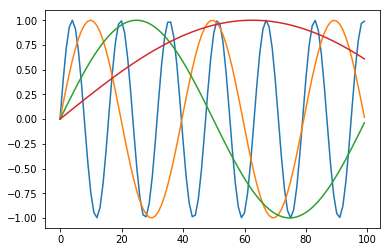

In [0]:
tst_encoding = PositionalEncoding(20)
res = tst_encoding(torch.arange(0,100).float())
_, ax = plt.subplots(1,1)
for i in range(1,5): ax.plot(res[:,i])

In [0]:
res[:6,:6]

tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.8415,  0.3877,  0.1578,  0.0631,  0.0251,  0.0100],
        [ 0.9093,  0.7147,  0.3117,  0.1259,  0.0502,  0.0200],
        [ 0.1411,  0.9300,  0.4578,  0.1882,  0.0753,  0.0300],
        [-0.7568,  0.9998,  0.5923,  0.2497,  0.1003,  0.0400],
        [-0.9589,  0.9132,  0.7121,  0.3103,  0.1253,  0.0500]])

In [0]:
class TransformerEmbedding(nn.Module):
    "Embedding + positional encoding + dropout"
    def __init__(self, vocab_sz, emb_sz, inp_p=0.):
        super().__init__()
        self.emb_sz = emb_sz
        self.embed = embedding(vocab_sz, emb_sz)
        self.pos_enc = PositionalEncoding(emb_sz)
        self.drop = nn.Dropout(inp_p)
    
    def forward(self, inp): 
        pos = torch.arange(0, inp.size(1), device=inp.device).float()
        return self.drop(self.embed(inp) * math.sqrt(self.emb_sz) + self.pos_enc(pos))

### Feed forward

In [0]:
def feed_forward(d_model, d_ff, ff_p=0., double_drop=True):
    layers = [nn.Linear(d_model, d_ff), nn.ReLU()]
    if double_drop: layers.append(nn.Dropout(ff_p))
    return SequentialEx(*layers, nn.Linear(d_ff, d_model), nn.Dropout(ff_p), MergeLayer(), nn.LayerNorm(d_model))

### Multi-head attention

![Multi head attention](https://github.com/fastai/course-nlp/blob/master/images/attention.png?raw=1)

In [0]:
class MultiHeadAttention(nn.Module):
    def __init__(self, n_heads, d_model, d_head=None, p=0., bias=True, scale=True):
        super().__init__()
        d_head = ifnone(d_head, d_model//n_heads)
        self.n_heads,self.d_head,self.scale = n_heads,d_head,scale
        self.q_wgt,self.k_wgt,self.v_wgt = [nn.Linear(
            d_model, n_heads * d_head, bias=bias) for o in range(3)]
        self.out = nn.Linear(n_heads * d_head, d_model, bias=bias)
        self.drop_att,self.drop_res = nn.Dropout(p),nn.Dropout(p)
        self.ln = nn.LayerNorm(d_model)
        
    def forward(self, q, kv, mask=None):
        return self.ln(q + self.drop_res(self.out(self._apply_attention(q, kv, mask=mask))))
    
    def create_attn_mat(self, x, layer, bs):
        return layer(x).view(bs, x.size(1), self.n_heads, self.d_head
                            ).permute(0, 2, 1, 3)
    
    def _apply_attention(self, q, kv, mask=None):
        bs,seq_len = q.size(0),q.size(1)
        wq,wk,wv = map(lambda o: self.create_attn_mat(*o,bs),
                       zip((q,kv,kv),(self.q_wgt,self.k_wgt,self.v_wgt)))
        attn_score = wq @ wk.transpose(2,3)
        if self.scale: attn_score /= math.sqrt(self.d_head)
        if mask is not None: 
            attn_score = attn_score.float().masked_fill(mask, -float('inf')).type_as(attn_score)
        attn_prob = self.drop_att(F.softmax(attn_score, dim=-1))
        attn_vec = attn_prob @ wv
        return attn_vec.permute(0, 2, 1, 3).contiguous().view(bs, seq_len, -1)

### Masking

In [0]:
def get_output_mask(inp, pad_idx=1):
    return torch.triu(inp.new_ones(inp.size(1),inp.size(1)), diagonal=1)[None,None].byte()
#     return ((inp == pad_idx)[:,None,:,None].long() + torch.triu(inp.new_ones(inp.size(1),inp.size(1)), diagonal=1)[None,None] != 0)

### Encoder and decoder blocks

We are now ready to regroup these layers in the blocks we add in the model picture:

![Transformer model](https://github.com/fastai/course-nlp/blob/master/images/Transformer.png?raw=1)

In [0]:
class EncoderBlock(nn.Module):
    "Encoder block of a Transformer model."
    #Can't use Sequential directly cause more than one input...
    def __init__(self, n_heads, d_model, d_head, d_inner, p=0., bias=True, scale=True, double_drop=True):
        super().__init__()
        self.mha = MultiHeadAttention(n_heads, d_model, d_head, p=p, bias=bias, scale=scale)
        self.ff  = feed_forward(d_model, d_inner, ff_p=p, double_drop=double_drop)
    
    def forward(self, x, mask=None): return self.ff(self.mha(x, x, mask=mask))

In [0]:
class DecoderBlock(nn.Module):
    "Decoder block of a Transformer model."
    #Can't use Sequential directly cause more than one input...
    def __init__(self, n_heads, d_model, d_head, d_inner, p=0., bias=True, scale=True, double_drop=True):
        super().__init__()
        self.mha1 = MultiHeadAttention(n_heads, d_model, d_head, p=p, bias=bias, scale=scale)
        self.mha2 = MultiHeadAttention(n_heads, d_model, d_head, p=p, bias=bias, scale=scale)
        self.ff   = feed_forward(d_model, d_inner, ff_p=p, double_drop=double_drop)
    
    def forward(self, x, enc, mask_out=None): return self.ff(self.mha2(self.mha1(x, x, mask_out), enc))

### The whole model

In [0]:
class Transformer(Module):
    def __init__(self, inp_vsz, out_vsz, n_layers=6, n_heads=8, d_model=256, d_head=32, 
                 d_inner=1024, p=0.1, bias=True, scale=True, double_drop=True, pad_idx=1):
        self.enc_emb = TransformerEmbedding(inp_vsz, d_model, p)
        self.dec_emb = TransformerEmbedding(out_vsz, d_model, 0.)
        args = (n_heads, d_model, d_head, d_inner, p, bias, scale, double_drop)
        self.encoder = nn.ModuleList([EncoderBlock(*args) for _ in range(n_layers)])
        self.decoder = nn.ModuleList([DecoderBlock(*args) for _ in range(n_layers)])
        self.out = nn.Linear(d_model, out_vsz)
        self.out.weight = self.dec_emb.embed.weight
        self.pad_idx = pad_idx
        
    def forward(self, inp, out):
        mask_out = get_output_mask(out, self.pad_idx)
        enc,out = self.enc_emb(inp),self.dec_emb(out)
        enc = compose(self.encoder)(enc)
        out = compose(self.decoder)(out, enc, mask_out)
        return self.out(out)

#### Bleu metric

In [0]:
class NGram():
    def __init__(self, ngram, max_n=5000): self.ngram,self.max_n = ngram,max_n
    def __eq__(self, other):
        if len(self.ngram) != len(other.ngram): return False
        return np.all(np.array(self.ngram) == np.array(other.ngram))
    def __hash__(self): return int(sum([o * self.max_n**i for i,o in enumerate(self.ngram)]))

In [0]:
def get_grams(x, n, max_n=5000):
    return x if n==1 else [NGram(x[i:i+n], max_n=max_n) for i in range(len(x)-n+1)]

In [0]:
def get_correct_ngrams(pred, targ, n, max_n=5000):
    pred_grams,targ_grams = get_grams(pred, n, max_n=max_n),get_grams(targ, n, max_n=max_n)
    pred_cnt,targ_cnt = Counter(pred_grams),Counter(targ_grams)
    return sum([min(c, targ_cnt[g]) for g,c in pred_cnt.items()]),len(pred_grams)

In [0]:
class CorpusBLEU(Callback):
    def __init__(self, vocab_sz):
        self.vocab_sz = vocab_sz
        self.name = 'bleu'
    
    def on_epoch_begin(self, **kwargs):
        self.pred_len,self.targ_len,self.corrects,self.counts = 0,0,[0]*4,[0]*4
    
    def on_batch_end(self, last_output, last_target, **kwargs):
        last_output = last_output.argmax(dim=-1)
        for pred,targ in zip(last_output.cpu().numpy(),last_target.cpu().numpy()):
            self.pred_len += len(pred)
            self.targ_len += len(targ)
            for i in range(4):
                c,t = get_correct_ngrams(pred, targ, i+1, max_n=self.vocab_sz)
                self.corrects[i] += c
                self.counts[i]   += t
    
    def on_epoch_end(self, last_metrics, **kwargs):
        precs = [c/t for c,t in zip(self.corrects,self.counts)]
        len_penalty = exp(1 - self.targ_len/self.pred_len) if self.pred_len < self.targ_len else 1
        bleu = len_penalty * ((precs[0]*precs[1]*precs[2]*precs[3]) ** 0.25)
        return add_metrics(last_metrics, bleu)

### Training

In [0]:
n_x_vocab,n_y_vocab = len(data.train_ds.x.vocab.itos), len(data.train_ds.y.vocab.itos)

model = Transformer(n_x_vocab, n_y_vocab, d_model=256)
learn = Learner(data, model, metrics=[accuracy, CorpusBLEU(n_y_vocab)], loss_func = CrossEntropyFlat())

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


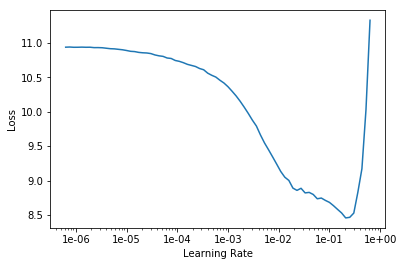

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(8, 1e-3, div_factor=5)

epoch,train_loss,valid_loss,accuracy,bleu,time
0,3.066520,3.117959,0.551051,0.328840,11:16
1,2.206446,2.354458,0.630671,0.393335,11:25
2,2.009659,2.094535,0.658308,0.419734,11:12
3,1.774151,1.933175,0.676711,0.439471,11:17
4,1.624831,1.813894,0.695347,0.460836,11:24
5,1.393484,1.743363,0.708348,0.475993,11:25
6,1.284289,1.710711,0.715625,0.484429,11:23
7,1.126550,1.709512,0.717463,0.486723,11:22


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in long_scalars
  


In [0]:
jlearn.fit_one_cycle(8, 5e-4, div_factor=5)

epoch,train_loss,valid_loss,accuracy,bleu,time
0,3.334582,3.570136,0.498652,0.294986,11:22
1,2.419559,2.543997,0.615261,0.378170,11:20
2,2.086362,2.118462,0.661029,0.422816,11:23
3,1.768372,1.922026,0.682879,0.446931,11:24
4,1.596714,1.806425,0.697513,0.462863,11:16
5,1.380304,1.733427,0.710721,0.477835,11:15
6,1.333426,1.713831,0.715306,0.483889,11:15
7,1.210745,1.714322,0.716311,0.484944,11:26


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in long_scalars
  


In [0]:
def get_predictions(learn, ds_type=DatasetType.Valid):
    learn.model.eval()
    inputs, targets, outputs = [],[],[]
    with torch.no_grad():
        for xb,yb in progress_bar(learn.dl(ds_type)):
            out = learn.model(*xb)
            for x,y,z in zip(xb[0],xb[1],out):
                inputs.append(learn.data.train_ds.x.reconstruct(x))
                targets.append(learn.data.train_ds.y.reconstruct(y))
                outputs.append(learn.data.train_ds.y.reconstruct(z.argmax(1)))
    return inputs, targets, outputs

In [0]:
inputs, targets, outputs = get_predictions(learn)

In [0]:
inputs[700],targets[700],outputs[700]

(Text xxbos trump ’s simplistic , xenophobic rhetoric will also find a sympathetic audience among poles and hungarians who fear large - scale immigration .,
 Text xxbos trumps vereinfachende , xxunk rhetorik wird auch bei jenen polen und ungarn anklang finden , die sich vor umfangreicher zuwanderung fürchten .,
 Text xxbos trumps allzu , fremdenfeindliche rhetorik wird auch unter polen polen und ungarn mit finden , die die vor großen einwanderung fürchten .)

In [0]:
inputs[701],targets[701],outputs[701]

(Text xxbos my portal to the world of artificial intelligence is a narrow one : the more than xxunk - old game of chess .,
 Text xxbos mein eigener zugang zur welt der künstlichen intelligenz ist ein eng xxunk : das über 500 jahre alte xxunk schach .,
 Text xxbos meine xxunk xxunk zur welt der künstlichen intelligenz ist ein eng xxunk : je mehr xxunk - alten spiel . .)

In [0]:
inputs[2000],targets[2000],outputs[2000]

(Text xxbos the transition from autocracy to democracy in the middle east is likely to be bumpy and unstable , at best .,
 Text xxbos der übergang von der autokratie zur demokratie i m nahen osten wird wahrscheinlich holprig und instabil verlaufen – bestenfalls .,
 Text xxbos der übergang von autokratie autokratie zur demokratie i m nahen osten dürfte bestenfalls ein und instabil sein . bestenfalls .)

In [0]:
inputs[2513],targets[2513],outputs[2513]

(Text xxbos but it is time to go further and begin to lobby aggressively for faster financial liberalization in the developing world .,
 Text xxbos es ist allerdings an der zeit , sich darüber hinaus mit mehr nachdruck für eine raschere finanzliberalisierung in den entwicklungsländern einzusetzen .,
 Text xxbos doch ist jedoch an der zeit , sich weiter zu weiter einer zu zu eine schnellere liberalisierung in den entwicklungsländern zu .)

In [0]:
for i in range(50):
  print(inputs[i])
  print(targets[i])
  print(outputs[i])
  print()

xxbos they are , however , preparing for a higher - interest - rate world , one marked by a transitional slowdown in growth .
xxbos sie bereiten sich jedoch auf eine welt höherer zinsen vor , die durch eine vorübergehende wachstumsabschwächung gekennzeichnet ist .
xxbos sie bereiten sich jedoch auf eine höhere mit zinssätze vor , die durch einen verlangsamung verlangsamung eintritt ist .

xxbos so , in all likelihood , the world has been spared a policy that would be as futile as it would be destructive .
xxbos also wurde der welt aller wahrscheinlichkeit nach eine maßnahme erspart , die ebenso zwecklos wie zerstörerisch gewesen wäre .
xxbos die blieb die welt trotz wahrscheinlichkeit einer einer politik erspart , die ebenso vergeblich wäre sinnlos wäre wäre .

xxbos on a similar scale , a vaccine to prevent human papilloma virus infection and cervical cancer was tested in almost 30,000 young women .
xxbos in ähnlicher weise wurde ein impfstoff gegen das humane papillomavirus und gebär